<a href="https://colab.research.google.com/github/sudeozkanoglu/malaria_detect_deep_learning/blob/main/Copy_of_Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
#KÜTÜPHANELERİ IMPORT ETME
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import tensorflow as tf
import kagglehub
import shutil
import cv2
import matplotlib.cm as cm

from google.colab import drive
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from google.colab import drive


In [2]:
# DATASET İNDİRME
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cell-images-for-detecting-malaria


In [3]:
# TRAIN - VALIDATION VE TEST OLARAK DATASET'İ AYIRMA

# Ana klasör yolu
source_dir = os.path.join(path, 'cell_images')

# Hedef klasörler
base_dir = '/kaggle/working/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Train/Val/Test oranları
train_split = 0.7
val_split = 0.15
test_split = 0.15

# İlk olarak hedef klasörleri oluştur
for split_dir in [train_dir, val_dir, test_dir]:
    for label in ['Parasitized', 'Uninfected']:
        os.makedirs(os.path.join(split_dir, label), exist_ok=True)

# Her sınıf için işlemler
for label in ['Parasitized', 'Uninfected']:
    img_dir = os.path.join(source_dir, label)
    images = os.listdir(img_dir)
    random.shuffle(images)

    total_images = len(images)
    train_count = int(train_split * total_images)
    val_count = int(val_split * total_images)

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Kopyala
    for img_set, split_name in zip([train_images, val_images, test_images], ['train', 'val', 'test']):
        for img in img_set:
            src = os.path.join(img_dir, img)
            dst = os.path.join(base_dir, split_name, label, img)
            shutil.copyfile(src, dst)

print("Veri başarıyla train/val/test olarak bölündü!")

Veri başarıyla train/val/test olarak bölündü!


In [4]:
# TRAIN - VALIDATION VE TEST KLASÖRLERİNİN İNCELENMESİ

# Bölünmüş verinin olduğu ana klasör
base_dir = '/kaggle/working/data'

# Train, val ve test klasörleri için
for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()} set:")
    for label in ['Parasitized', 'Uninfected']:
        folder = os.path.join(base_dir, split, label)
        count = len(os.listdir(folder))
        print(f"{label}: {count} görüntü")


TRAIN set:
Parasitized: 9646 görüntü
Uninfected: 9646 görüntü

VAL set:
Parasitized: 2067 görüntü
Uninfected: 2067 görüntü

TEST set:
Parasitized: 2067 görüntü
Uninfected: 2067 görüntü


In [5]:
# EKSİK VERİLERİN KONTROLÜ

# 1. image_dataset_from_directory ile veri setlerini oluşturuyoruz

base_dir = '/kaggle/working/data'

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=(64, 64),
    batch_size=32,
    shuffle=False  # Shuffle kapalı olsun ki index takip edelim
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    image_size=(64, 64),
    batch_size=32,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=(64, 64),
    batch_size=32,
    shuffle=False
)

print("\nDatasets başarıyla oluşturuldu")

# 2. Eksik veri kontrol fonksiyonu (batch destekli)

def check_missing(ds, name="dataset"):
    missing_image_count = 0
    missing_label_count = 0

    for i, (images, labels) in enumerate(ds):
        images_np = images.numpy()
        labels_np = labels.numpy()

        batch_size = images_np.shape[0]

        for j in range(batch_size):
            img = images_np[j]
            lbl = labels_np[j]

            if img.size == 0:
                print(f"[{name}] Eksik görsel - Batch {i}, Index {j}")
                missing_image_count += 1
            if lbl is None:
                print(f"[{name}] Eksik etiket - Batch {i}, Index {j}")
                missing_label_count += 1

    if missing_image_count == 0 and missing_label_count == 0:
        print(f"{name}: Eksik veri bulunamadı")
    else:
        print(f"{name}: {missing_image_count} eksik görsel, {missing_label_count} eksik etiket")

# 3. Datasetler için eksik veri kontrolü yapıyoruz

check_missing(train_ds, name="Train Seti")
check_missing(val_ds, name="Validation Seti")
check_missing(test_ds, name="Test Seti")

Found 19290 files belonging to 2 classes.
Found 4134 files belonging to 2 classes.
Found 4134 files belonging to 2 classes.

Datasets başarıyla oluşturuldu
Train Seti: Eksik veri bulunamadı
Validation Seti: Eksik veri bulunamadı
Test Seti: Eksik veri bulunamadı


In [6]:
# OUTLIER KONTROLÜ

# Outlier kontrolü fonksiyonu (batch destekli)
def check_outliers(ds, name="dataset"):
    small_image_count = 0
    bright_image_count = 0

    for i, (images, labels) in enumerate(ds):
        images_np = images.numpy()
        labels_np = labels.numpy()

        batch_size = images_np.shape[0]

        for j in range(batch_size):
            img = images_np[j]
            lbl = labels_np[j]

            # Şekil kontrolü (çok küçük görüntüler)
            if img.shape[0] < 20 or img.shape[1] < 20:
                print(f"[{name}] Küçük resim - Batch {i}, Index {j}, shape: {img.shape}")
                small_image_count += 1

            # Ortalama parlaklık kontrolü
            mean_brightness = np.mean(img)
            if mean_brightness < 5 or mean_brightness > 250:
                print(f"[{name}] Şüpheli parlaklık - Batch {i}, Index {j}, mean brightness: {mean_brightness:.2f}")
                bright_image_count += 1

    if small_image_count == 0 and bright_image_count == 0:
        print(f"{name}: Outlier bulunamadı")
    else:
        print(f"{name}: {small_image_count} küçük resim ve {bright_image_count} şüpheli parlaklık bulundu")

# Kullanım
check_outliers(train_ds, name="Train Seti")
check_outliers(val_ds, name="Validation Seti")
check_outliers(test_ds, name="Test Seti")

Train Seti: Outlier bulunamadı
Validation Seti: Outlier bulunamadı
Test Seti: Outlier bulunamadı


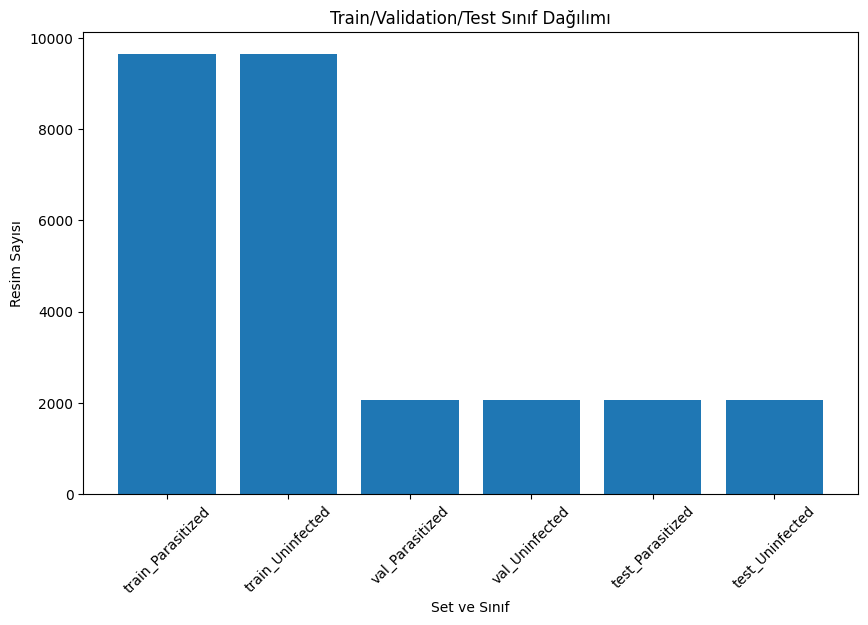

In [7]:
# SINIF DAĞILIMI GRAFİĞİ - HİSTOGRAM

# Sınıf sayısını sayalım
labels = ['Parasitized', 'Uninfected']
counts = {}

for split in ['train', 'val', 'test']:
    for label in labels:
        folder = os.path.join(base_dir, split, label)
        count = len(os.listdir(folder))
        counts[f"{split}_{label}"] = count

# Histogram çizimi
plt.figure(figsize=(10,6))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=45)
plt.xlabel('Set ve Sınıf')
plt.ylabel('Resim Sayısı')
plt.title('Train/Validation/Test Sınıf Dağılımı')
plt.show()

In [8]:
#RANDOM SEED OLUŞTURMA
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [9]:
#IMAGE VE BATCH SIZE BELİRLEME
IMAGE_SIZE = (224, 224)  # Transfer learning girişine göre görüntü boyutu
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# RESNET50

#IMAGE GENERATOR - RESNET50
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

valid_datagen_resnet = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

test_datagen_resnet = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [ ]:
#GENERATOR FOR TRAIN, VALIDATION, TEST - RESNET50
train_generator_resnet = train_datagen_resnet.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator_resnet = valid_datagen_resnet.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_resnet = test_datagen_resnet.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 19291 images belonging to 2 classes.
Found 4133 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.


In [ ]:
#LOAD RESNET50
# ResNet50 modelini önceden eğitilmiş ağırlıklarla yükleyin
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# başlangıç ​​eğitimi sırasında ağırlıklarının güncellenmemesi için base_model'i dondurun
resnet_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
res_model = Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 sınıf
])

res_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
optimizer_res = Adam(learning_rate=0.001)

res_model.compile(
    optimizer=optimizer_res,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#TRAIN MODEL

EPOCHS = 10

# Erken durdurma ve öğrenme oranı azaltma için geri aramalar eklendi
res_early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
res_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)

res_history = res_model.fit(
    train_generator_resnet,
    epochs=EPOCHS,
    validation_data=valid_generator_resnet,
    callbacks=[res_early_stop, res_reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 270s 425ms/step - accuracy: 0.8358 - loss: 0.4389 - val_accuracy: 0.8875 - val_loss: 0.2656 - learning_rate: 0.0010
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 245s 407ms/step - accuracy: 0.9143 - loss: 0.2280 - val_accuracy: 0.8836 - val_loss: 0.2767 - learning_rate: 0.0010
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 249s 413ms/step - accuracy: 0.9227 - loss: 0.2125 - val_accuracy: 0.9025 - val_loss: 0.2392 - learning_rate: 0.0010
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 249s 414ms/step - accuracy: 0.9232 - loss: 0.2069 - val_accuracy: 0.9267 - val_loss: 0.1960 - learning_rate: 0.0010
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 243s 403ms/step - accuracy: 0.9271 - loss: 0.1983 - val_accuracy: 0.9134 - val_loss: 0.2183 - learning_rate: 0.0010
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 242s 402ms/step - accuracy: 0.9275 - loss: 0.2018 - val_accuracy: 0.8969 - val_loss: 0.2505 - learning_rate: 0.0010
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 243s 403ms/step - accura

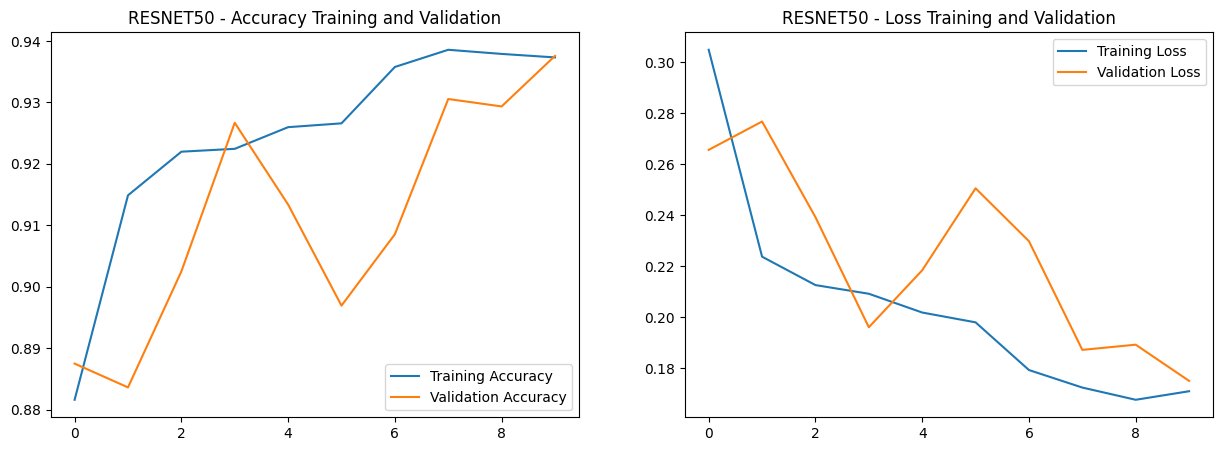

In [ ]:
#VISUALIZING THE TRAINING
# Accuracy ve Loss Grafiği
acc_res = res_history.history['accuracy']
val_acc_res = res_history.history['val_accuracy']

loss_res = res_history.history['loss']
val_loss_res = res_history.history['val_loss']

epochs_range_res = range(len(acc_res))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs_range_res, acc_res, label='Training Accuracy')
plt.plot(epochs_range_res, val_acc_res, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('RESNET50 - Accuracy Training and Validation')

plt.subplot(1,2,2)
plt.plot(epochs_range_res, loss_res, label='Training Loss')
plt.plot(epochs_range_res, val_loss_res, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('RESNET50 - Loss Training and Validation')
plt.show()

In [ ]:
# Get predictions - ResNet
test_generator_resnet.reset()
preds_res = res_model.predict(test_generator_resnet, verbose=1)
y_pred_res = np.argmax(preds_res, axis=1)
y_true_res = test_generator_resnet.classes

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step


In [ ]:
# Get Class Name - ResNet
class_indices_res = test_generator_resnet.class_indices
class_names_res = list(class_indices_res.keys())

print('RESNET50 - Classification Report')
print(classification_report(y_true_res, y_pred_res, target_names=class_names_res))

RESNET50 - Classification Report
              precision    recall  f1-score   support

 Parasitized       0.96      0.92      0.94      2067
  Uninfected       0.93      0.96      0.94      2067

    accuracy                           0.94      4134
   macro avg       0.94      0.94      0.94      4134
weighted avg       0.94      0.94      0.94      4134



In [ ]:
accuracy_res = accuracy_score(y_true_res, y_pred_res)
precision_res = precision_score(y_true_res, y_pred_res, average='macro')
recall_res = recall_score(y_true_res, y_pred_res, average='macro')
f1score_res = f1_score(y_true_res, y_pred_res, average='macro')

print('RESNET50')
print('--------------------------')
print('Accuracy:', accuracy_res)
print('Precision:', precision_res)
print('Recall:', recall_res)
print('F1-score:', f1score_res)

RESNET50
--------------------------
Accuracy: 0.9404934687953556
Precision: 0.9410285883010472
Recall: 0.9404934687953557
F1-score: 0.9404754128413303


In [ ]:
# EFFICIENTNET

#IMAGE GENERATOR
train_datagen_efficient = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

valid_datagen_efficient = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_datagen_efficient = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [ ]:
#GENERATOR FOR TRAIN, VALIDATION, TEST
train_generator_efficient = train_datagen_efficient.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator_efficient = valid_datagen_efficient.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_efficient = test_datagen_efficient.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 19291 images belonging to 2 classes.
Found 4133 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.


In [ ]:
#LOAD EfficientNetB0

# EfficientNetB0 modelini önceden eğitilmiş ağırlıklarla yükleyin
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# başlangıç ​​eğitimi sırasında ağırlıklarının güncellenmemesi için base_model'i dondurun
efficientnet_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
efficient_model = Sequential([
    efficientnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 sınıf
])

efficient_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
efficient_optimizer = Adam(learning_rate=0.001)

efficient_model.compile(
    optimizer=efficient_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#TRAIN MODEL

EPOCHS = 10

# Erken durdurma ve öğrenme oranı azaltma için geri aramalar eklendi
efficient_early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
efficient_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)

efficient_history = efficient_model.fit(
    train_generator_efficient,
    epochs=EPOCHS,
    validation_data=valid_generator_efficient,
    callbacks=[efficient_early_stop, efficient_reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 274s 418ms/step - accuracy: 0.8906 - loss: 0.2740 - val_accuracy: 0.9279 - val_loss: 0.1971 - learning_rate: 0.0010
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 231s 383ms/step - accuracy: 0.9290 - loss: 0.1881 - val_accuracy: 0.9301 - val_loss: 0.1866 - learning_rate: 0.0010
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 237s 392ms/step - accuracy: 0.9333 - loss: 0.1797 - val_accuracy: 0.9359 - val_loss: 0.1719 - learning_rate: 0.0010
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 228s 378ms/step - accuracy: 0.9366 - loss: 0.1664 - val_accuracy: 0.9293 - val_loss: 0.1930 - learning_rate: 0.0010
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 227s 377ms/step - accuracy: 0.9413 - loss: 0.1606 - val_accuracy: 0.9361 - val_loss: 0.1740 - learning_rate: 0.0010
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 228s 378ms/step - accuracy: 0.9410 - loss: 0.1514 - val_accuracy: 0.9385 - val_loss: 0.1675 - learning_rate: 5.0000e-04
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 261s 376ms/step - ac

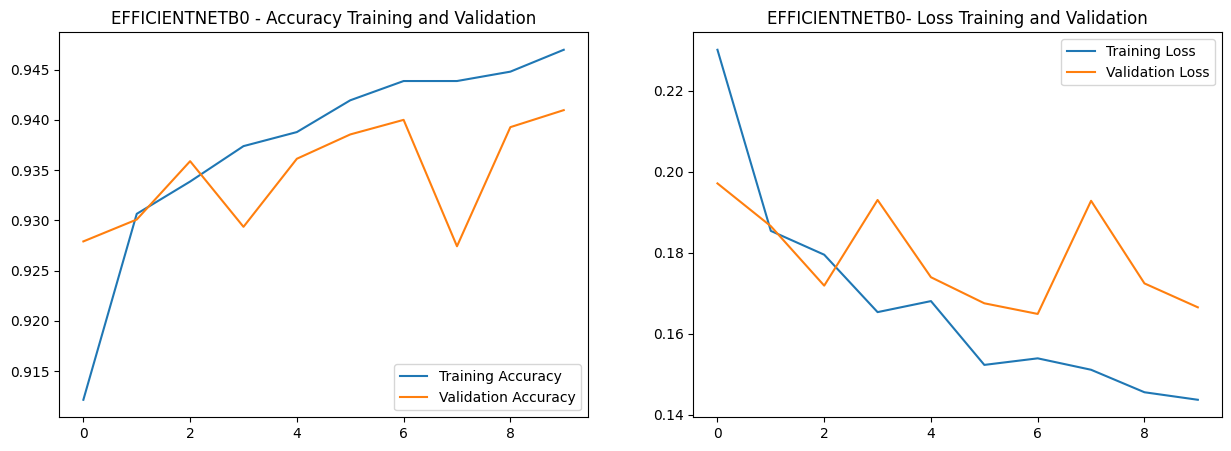

In [ ]:
#VISUALIZING THE TRAINING
# Accuracy ve Loss Grafiği
efficient_acc = efficient_history.history['accuracy']
efficient_val_acc = efficient_history.history['val_accuracy']

efficient_loss = efficient_history.history['loss']
efficient_val_loss = efficient_history.history['val_loss']

efficient_epochs_range = range(len(efficient_acc))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(efficient_epochs_range, efficient_acc, label='Training Accuracy')
plt.plot(efficient_epochs_range, efficient_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('EFFICIENTNETB0 - Accuracy Training and Validation')

plt.subplot(1,2,2)
plt.plot(efficient_epochs_range, efficient_loss, label='Training Loss')
plt.plot(efficient_epochs_range, efficient_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('EFFICIENTNETB0- Loss Training and Validation')
plt.show()

In [ ]:
# Get predictions - EfficientNet
test_generator_efficient.reset()
efficient_preds = efficient_model.predict(test_generator_efficient, verbose=1)
y_pred_efficient = np.argmax(efficient_preds, axis=1)
y_true_efficient = test_generator_efficient.classes

130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step


In [ ]:
# Get Class Name - EfficientNet
class_indices_efficient = test_generator_efficient.class_indices
class_names_efficient = list(class_indices_efficient.keys())

print('EFFICIENTNETB0 - Classification Report')
print(classification_report(y_true_efficient, y_pred_efficient, target_names=class_names_efficient))

EFFICIENTNETB0 - Classification Report
              precision    recall  f1-score   support

 Parasitized       0.96      0.93      0.94      2067
  Uninfected       0.93      0.96      0.94      2067

    accuracy                           0.94      4134
   macro avg       0.94      0.94      0.94      4134
weighted avg       0.94      0.94      0.94      4134



In [ ]:
accuracy_efficient = accuracy_score(y_true_efficient, y_pred_efficient)
precision_efficient = precision_score(y_true_efficient, y_pred_efficient, average='macro')
recall_efficient = recall_score(y_true_efficient, y_pred_efficient, average='macro')
f1score_efficient = f1_score(y_true_efficient, y_pred_efficient, average='macro')

print('EFFICIENTNETB0')
print('--------------------------')
print('Accuracy:', accuracy_efficient)
print('Precision:', precision_efficient)
print('Recall:', recall_efficient)
print('F1-score:', f1score_efficient)

EFFICIENTNETB0
--------------------------
Accuracy: 0.9436381228834059
Precision: 0.9442546219905498
Recall: 0.9436381228834059
F1-score: 0.9436185625321243


In [10]:
# MOBILENET

#IMAGE GENERATOR
train_datagen_mobile = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

valid_datagen_mobile = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_datagen_mobile = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
#GENERATOR FOR TRAIN, VALIDATION, TEST
train_generator_mobile = train_datagen_mobile.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator_mobile = valid_datagen_mobile.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_mobile = test_datagen_mobile.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 19290 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.


In [12]:
#LOAD MobileNetV2

# MobileNetV2 modelini önceden eğitilmiş ağırlıklarla yükleyin
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# başlangıç ​​eğitimi sırasında ağırlıklarının güncellenmemesi için base_model'i dondurun
mobilenet_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [41]:
# mobile_model = Sequential([
#     mobilenet_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(2, activation='softmax')  # 2 sınıf
# ])

# mobile_model.summary()

inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = mobilenet_model(inputs, training=False)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)

mobile_model = tf.keras.Model(inputs, outputs)

mobile_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,012,482 (11.49 MB)

 Trainable params: 754,498 (2.88 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [42]:
mobile_optimizer = Adam(learning_rate=0.001)

mobile_model.compile(
    optimizer=mobile_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [43]:
#TRAIN MODEL

EPOCHS = 10

# Erken durdurma ve öğrenme oranı azaltma için geri aramalar eklendi
mobile_early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mobile_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)

mobile_history = mobile_model.fit(
    train_generator_mobile,
    epochs=EPOCHS,
    validation_data=valid_generator_mobile,
    callbacks=[mobile_early_stop, mobile_reduce_lr]
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 265s 423ms/step - accuracy: 0.8997 - loss: 0.2709 - val_accuracy: 0.9257 - val_loss: 0.2020 - learning_rate: 0.0010
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 239s 397ms/step - accuracy: 0.9447 - loss: 0.1657 - val_accuracy: 0.9294 - val_loss: 0.1914 - learning_rate: 0.0010
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 266s 404ms/step - accuracy: 0.9485 - loss: 0.1531 - val_accuracy: 0.9386 - val_loss: 0.1611 - learning_rate: 0.0010
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 248s 412ms/step - accuracy: 0.9466 - loss: 0.1567 - val_accuracy: 0.9427 - val_loss: 0.1573 - learning_rate: 0.0010
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 242s 402ms/step - accuracy: 0.9492 - loss: 0.1479 - val_accuracy: 0.9405 - val_loss: 0.1712 - learning_rate: 0.0010
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 242s 401ms/step - accuracy: 0.9516 - loss: 0.1399 - val_accuracy: 0.9434 - val_loss: 0.1613 - learning_rate: 0.0010
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 239s 397ms/step - accura

In [46]:
mobile_model.save("mobilenet_malaria_model.keras")

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


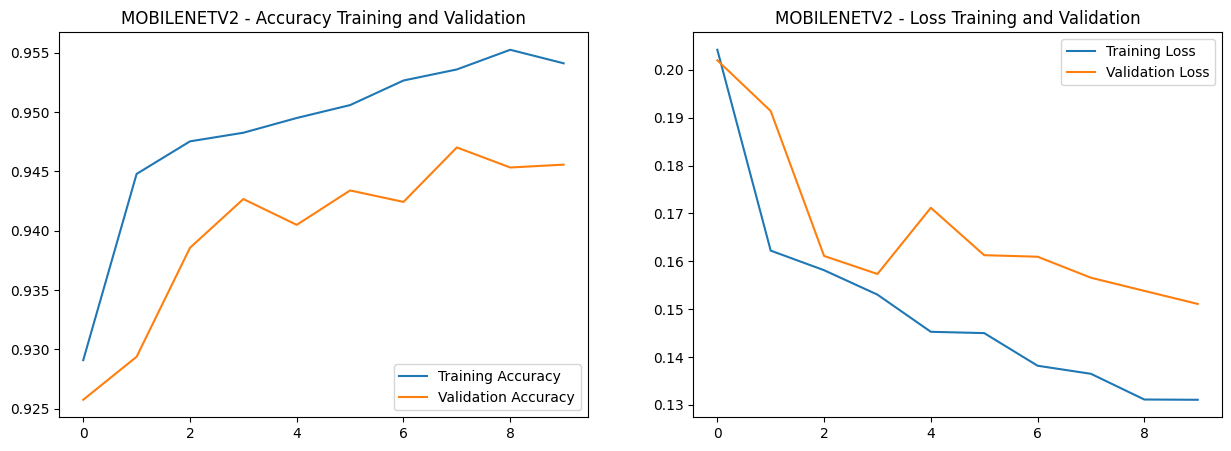

In [48]:
#VISUALIZING THE TRAINING
# Accuracy ve Loss Grafiği
mobile_acc = mobile_history.history['accuracy']
mobile_val_acc = mobile_history.history['val_accuracy']

mobile_loss = mobile_history.history['loss']
mobile_val_loss = mobile_history.history['val_loss']

mobile_epochs_range = range(len(mobile_acc))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(mobile_epochs_range, mobile_acc, label='Training Accuracy')
plt.plot(mobile_epochs_range, mobile_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('MOBILENETV2 - Accuracy Training and Validation')

plt.subplot(1,2,2)
plt.plot(mobile_epochs_range, mobile_loss, label='Training Loss')
plt.plot(mobile_epochs_range, mobile_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('MOBILENETV2 - Loss Training and Validation')
plt.show()

In [49]:
# Get predictions - MobileNet
test_generator_mobile.reset()
mobile_preds = mobile_model.predict(test_generator_mobile, verbose=1)
y_pred_mobile = np.argmax(mobile_preds, axis=1)
y_true_mobile = test_generator_mobile.classes

130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step


In [50]:
# Get Class Name - MobileNet
class_indices_mobile = test_generator_mobile.class_indices
class_names_mobile = list(class_indices_mobile.keys())

print('MOBILENETV2 - Classification Report')
print(classification_report(y_true_mobile, y_pred_mobile, target_names=class_names_mobile))

MOBILENETV2 - Classification Report
              precision    recall  f1-score   support

 Parasitized       0.96      0.93      0.95      2067
  Uninfected       0.94      0.96      0.95      2067

    accuracy                           0.95      4134
   macro avg       0.95      0.95      0.95      4134
weighted avg       0.95      0.95      0.95      4134



In [51]:
accuracy_mobile = accuracy_score(y_true_mobile, y_pred_mobile)
precision_mobile = precision_score(y_true_mobile, y_pred_mobile, average='macro')
recall_mobile = recall_score(y_true_mobile, y_pred_mobile, average='macro')
f1score_mobile = f1_score(y_true_mobile, y_pred_mobile, average='macro')

print('MOBILENETV2')
print('--------------------------')
print('Accuracy:', accuracy_mobile)
print('Precision:', precision_mobile)
print('Recall:', recall_mobile)
print('F1-score:', f1score_mobile)

MOBILENETV2
--------------------------
Accuracy: 0.9477503628447025
Precision: 0.9480561639302103
Recall: 0.9477503628447025
F1-score: 0.94774144614866


In [55]:
for layer in mobile_model.layers:
    print(layer.name)

input_layer_2
mobilenetv2_1.00_224
conv2d
global_average_pooling2d_1
dense_2
dropout_1
dense_3


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


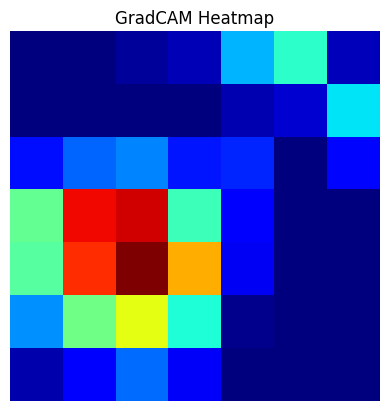

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Tahmin sonucu: [0.9580545  0.04194554] → Sınıf: Parasitic


In [85]:
# AÇIKLANABİLİR YAPAY ZEKA - MOBILENET
# Function to load and preprocess an image
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to generate GradCAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a sub-model for GradCAM using specified layers
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Compute the gradient of the top predicted class with respect to activations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradient of the output neuron with respect to feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Calculate the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weighted sum of feature map channels to create heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

drive.mount('/content/drive')
img_path = '/content/drive/MyDrive/parasitized.png'
model = load_model("/content/mobilenet_malaria_model.keras")
img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv2d", pred_index=None)

# Rescale heatmap to 0-255
heatmap = np.uint8(255 * heatmap)

# Apply a colormap for visualization
plt.imshow(heatmap, cmap='jet')
plt.axis('off')
plt.title('GradCAM Heatmap')
plt.show()

# Model tahmini
preds = model.predict(img_array)
pred_class_idx = np.argmax(preds[0])

# Sınıf isimleri (senin sınıf sırana göre düzenle)
class_names = ['Parasitic', 'Uninfected']

# Sonucu yazdır
print(f"Tahmin sonucu: {preds[0]} → Sınıf: {class_names[pred_class_idx]}")


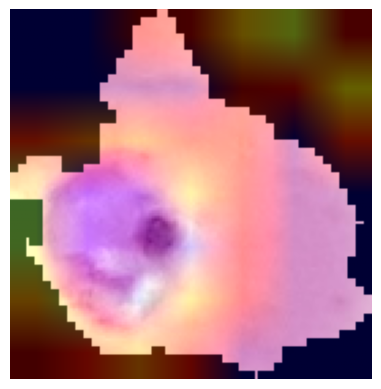

In [86]:
img = image.load_img(img_path)
img = image.img_to_array(img)

# Rescale heatmap to 0-255 and apply jet colormap
heatmap = np.uint8(255 * heatmap)
jet = plt.get_cmap("jet")  # Updated line
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Resize heatmap to match the dimensions of the original image
resized_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))

# Overlay heatmap on the original image
superimposed_img = resized_heatmap * 0.4 + img / 255.0
superimposed_img = np.clip(superimposed_img, 0, 1)

plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


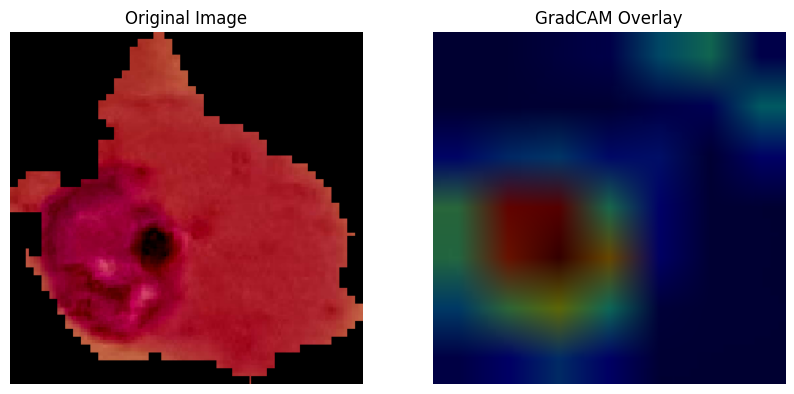

In [87]:
# Function to load and preprocess an image
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to generate GradCAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a sub-model for GradCAM using specified layers
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Compute the gradient of the top predicted class with respect to activations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradient of the output neuron with respect to feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Calculate the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weighted sum of feature map channels to create heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

drive.mount('/content/drive')
img_path = '/content/drive/MyDrive/parasitized.png'
model = load_model("/content/mobilenet_malaria_model.keras")
img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv2d", pred_index=None)

# Rescale heatmap to 0-255 and apply jet colormap
heatmap = np.uint8(255 * heatmap)
jet = plt.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Resize heatmap to match the dimensions of the original image
resized_heatmap = cv2.resize(jet_heatmap, (img_array.shape[2], img_array.shape[1]))

# Overlay heatmap on the original image
superimposed_img = resized_heatmap * 0.4 + img_array[0] / 255.0
superimposed_img = np.clip(superimposed_img, 0, 1)

# Display the original image and the superimposed image with heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_array[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('GradCAM Overlay')
plt.axis('off')

plt.show()

In [70]:
# KENDİ CNN MODELİMİZ

IMAGE_SIZE = (128,128)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

base_dir = '/kaggle/working/data'

train_ds = image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True
)

valid_ds = image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False
)

test_ds = image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False
)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 19290 files belonging to 2 classes.
Found 4134 files belonging to 2 classes.
Found 4134 files belonging to 2 classes.


In [71]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomCrop(112, 112),  # 128'den küçük bir parça alır (güzel varyasyon)
    layers.Resizing(128, 128),     # Sonra tekrar orijinale döndürür
])

In [72]:
inputs = layers.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# Block 1
x = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv1')(x)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.BatchNormalization()(x)

# Block 2
x = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv2')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.BatchNormalization()(x)

# Block 3
x = layers.Conv2D(128, (3,3), activation='relu', padding='same', name='conv3')(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.BatchNormalization()(x)

# Block 4 (ekstra katman)
x = layers.Conv2D(256, (3,3), activation='relu', padding='same', name='conv4')(x)
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.BatchNormalization()(x)

# Classifier
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,02

 Total params: 9,564,322 (36.48 MB)

 Trainable params: 9,563,362 (36.48 MB)

 Non-trainable params: 960 (3.75 KB)

In [73]:
EPOCHS = 10

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks= [early_stop, reduce_lr]
)

Epoch 1/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 68s 49ms/step - accuracy: 0.6602 - loss: 0.8516 - val_accuracy: 0.8503 - val_loss: 0.4043 - learning_rate: 1.0000e-04
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 71s 43ms/step - accuracy: 0.8685 - loss: 0.3502 - val_accuracy: 0.8887 - val_loss: 0.2830 - learning_rate: 1.0000e-04
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.8815 - loss: 0.3249 - val_accuracy: 0.9204 - val_loss: 0.2184 - learning_rate: 1.0000e-04
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.8875 - loss: 0.3073 - val_accuracy: 0.9231 - val_loss: 0.2106 - learning_rate: 1.0000e-04
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.9000 - loss: 0.2855 - val_accuracy: 0.8977 - val_loss: 0.2483 - learning_rate: 1.0000e-04
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.9038 - loss: 0.2702 - val_accuracy: 0.9090 - val_loss: 0.2259 - learning_rate: 1.0000e-04
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━

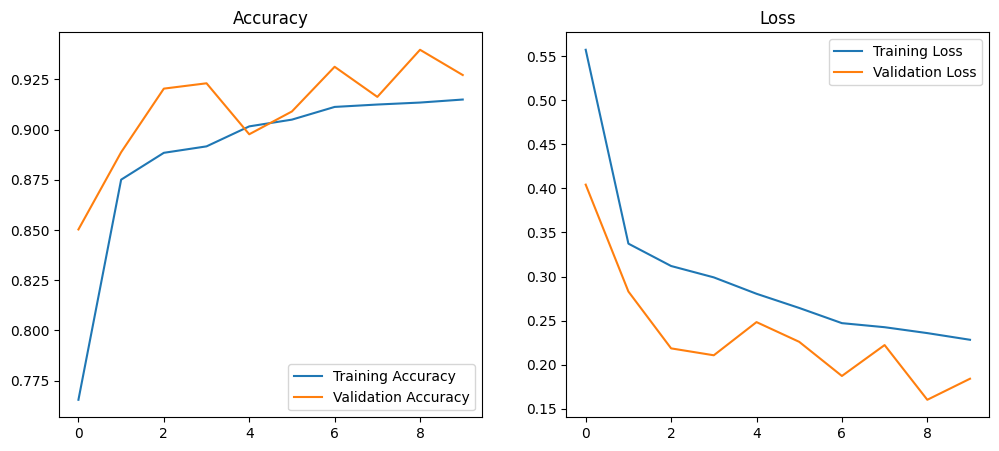

In [74]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [75]:
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━

In [76]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1score = f1_score(y_true, y_pred, average='macro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)

Accuracy: 0.9443638122883405
Precision: 0.9482312527667109
Recall: 0.9443638122883405
F1-score: 0.9442435424613905


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━

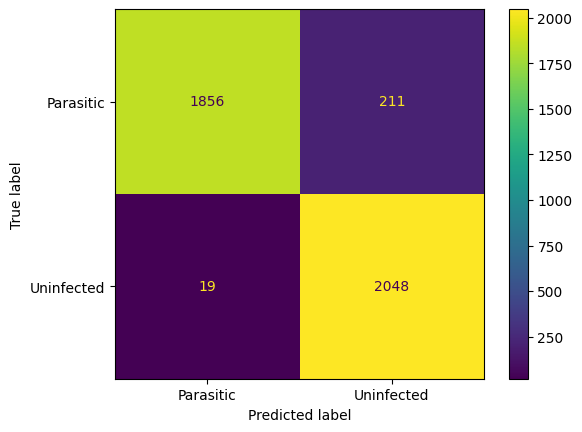

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()